In [13]:
from matplotlib import pyplot as plt


In [14]:
from src.well.find_well_props import find_well_props
import numpy as np
from src.filters import normalize_0_255
from src.models import InputImage

input_img = InputImage("zf6.jpg")
input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________


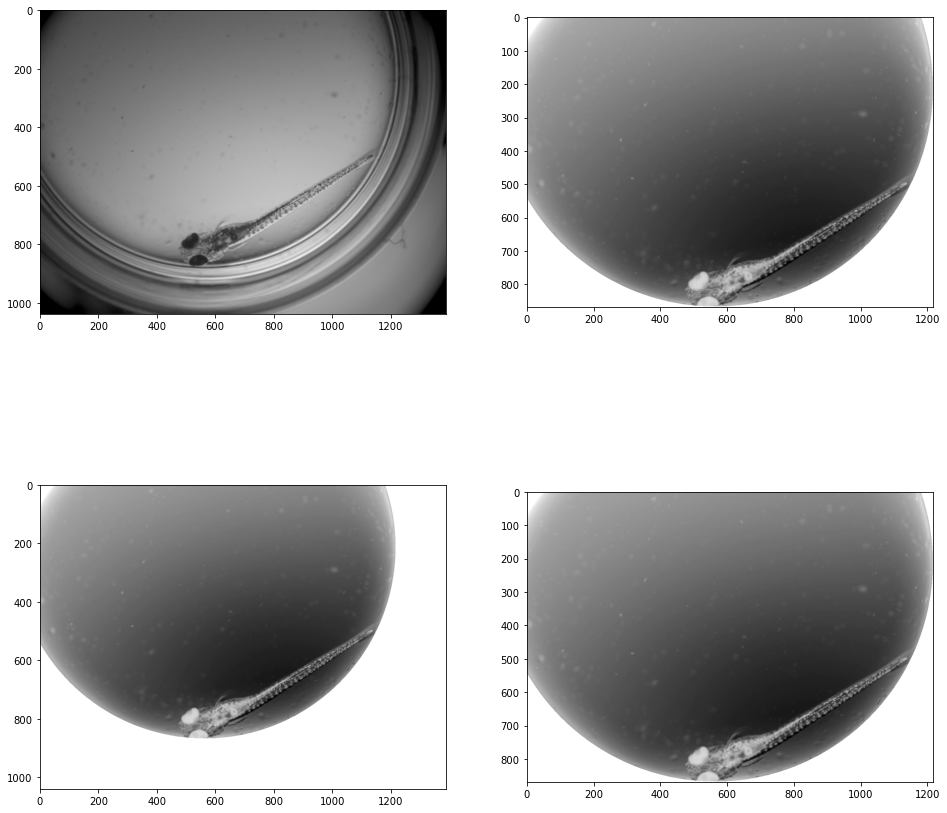

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

# Removing background
_____________________________________________________________


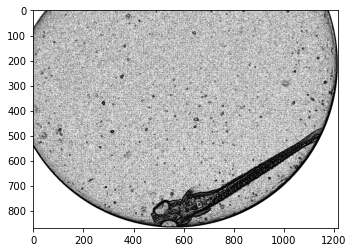

In [16]:
from src.fish.remove_background import remove_background

input_img.processed = input_img.well_props.mask.cropped_masked

input_img = remove_background(input_img)
r_bg = input_img.processed
plt.imshow(input_img.processed, 'binary')

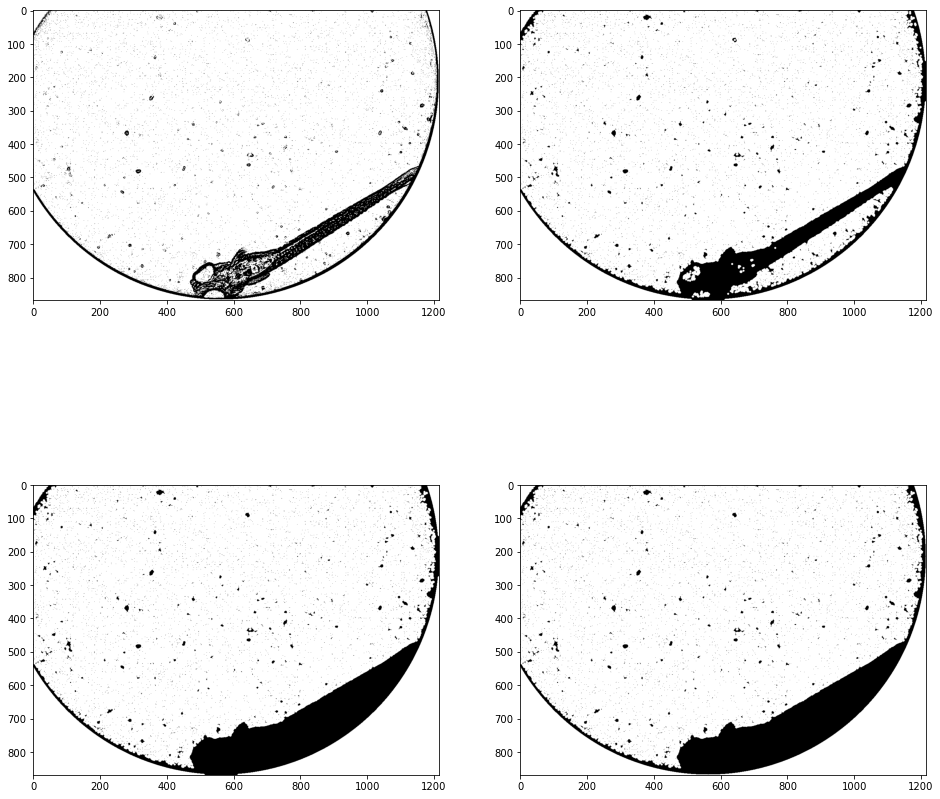

In [17]:
from src.filters import yen_th
from skimage.morphology import binary_closing, disk
from scipy.ndimage import binary_fill_holes

th = yen_th(r_bg)

closed = binary_closing(th, disk(3))
filled = binary_fill_holes(closed)
filled_masked = filled * input_img.well_props.mask.cropped

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(th, 'binary')
ax[1].imshow(closed, 'binary')
ax[2].imshow(filled, 'binary')
ax[3].imshow(filled_masked, 'binary')

input_img.processed = filled_masked

# Finding largest object
_____________________________________________________________
{'area': array([1476,    1,   28, ...,    2,    1,    5]), 'label': array([   1,    2,    3, ..., 5238, 5239, 5240]), 'image_filled': array([array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]]),
       array([[ True]]),
       array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False,  True],
       [False, False,  True, False,  True,  True,  True,  True, False,
        False, False, False, False, False],
       [False, False, False, False, False, Fa

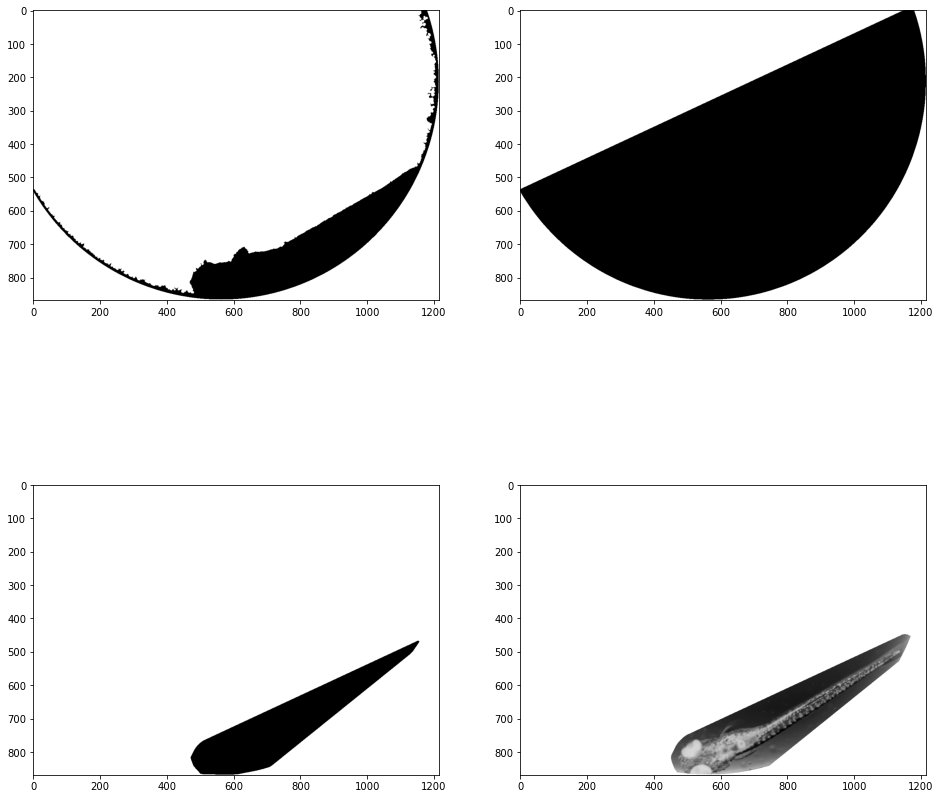

In [18]:
from src.fish.is_fish import is_fish
from src.fish.find_fish_props import refine_oversized_hull
from src.utils import keep_largest_object
from skimage.morphology import convex_hull_image, binary_dilation

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

klo = keep_largest_object(filled_masked)
fish_mask = convex_hull_image(klo).astype(float)

input_img.fish_props.mask.og = fish_mask

for i in range(6):
    if is_fish(input_img.fish_props.mask.og):
        break
    input_img = refine_oversized_hull(input_img, step=i + 1)

dilated_mask = binary_dilation(input_img.fish_props.mask.og, disk(20))
input_img.fish_props.mask.masked = dilated_mask * input_img.well_props.mask.cropped_masked
dilated_masked = input_img.fish_props.mask.masked

ax[0].imshow(klo, 'binary')
ax[1].imshow(fish_mask, 'binary')
ax[2].imshow(input_img.fish_props.mask.og, 'binary')
ax[3].imshow(dilated_masked, 'binary')

__________________________________________________________________
# Refine

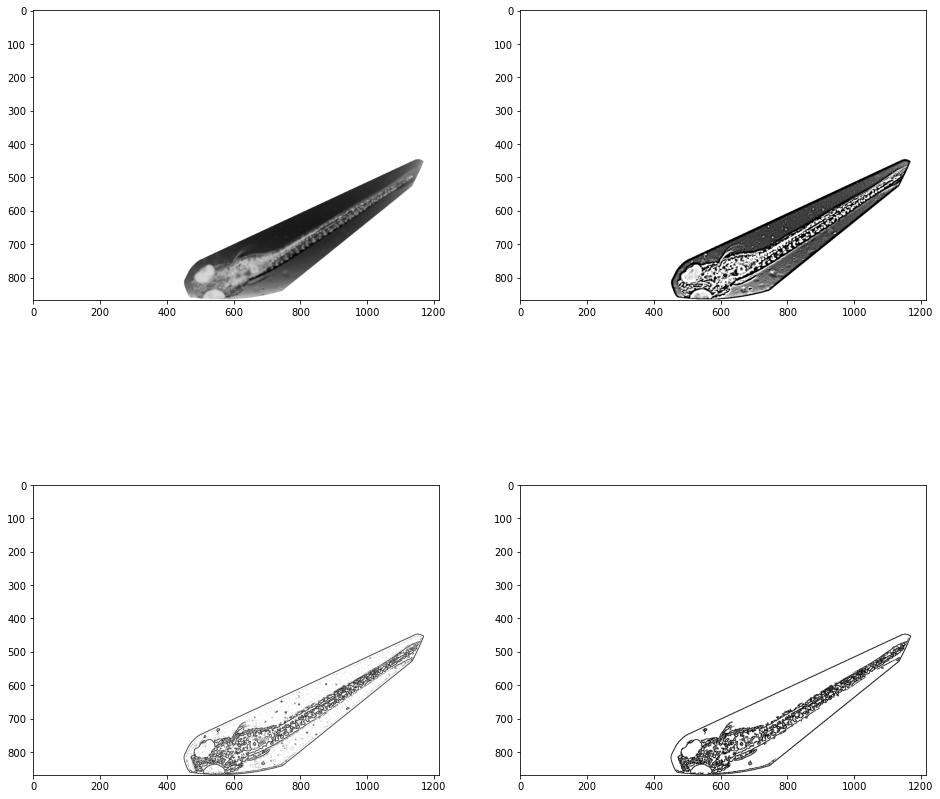

In [19]:
from src.utils import get_bounding_box_obj
from skimage.morphology import binary_erosion, remove_small_objects
from src.filters import sobel
from skimage.filters._unsharp_mask import unsharp_mask

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

um = unsharp_mask(dilated_masked, amount=20, radius=3)
sobel = sobel(um)

eroded_mask = binary_erosion(input_img.fish_props.mask.og, disk(5))

refined = remove_small_objects(yen_th(sobel))

ax[0].imshow(dilated_masked, 'binary')
ax[1].imshow(um, 'binary')
ax[2].imshow(sobel, 'binary')
ax[3].imshow(refined, 'binary')

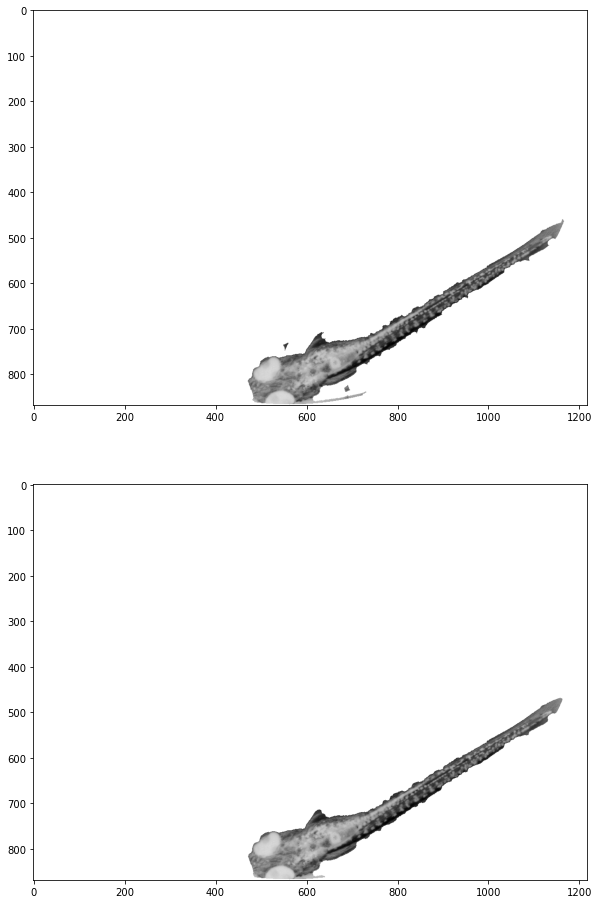

In [23]:
from skimage.morphology import binary_opening
from skimage.color import gray2rgb
import cv2

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))
ax = ax.ravel()

from skimage.measure import find_contours

ref = input_img.fish_props.mask.og.copy()

refffe = binary_fill_holes(binary_closing(refined * binary_erosion(dilated_mask, disk(10)), disk(5)))
fishy = refffe * input_img.well_props.mask.cropped_masked

ax[0].imshow(fishy, 'binary')

fishy = remove_small_objects(binary_opening(refffe, disk(5))) * input_img.well_props.mask.cropped_masked
ax[1].imshow(fishy, 'binary')

# Finding largest object
_____________________________________________________________
{'area': array([42725]), 'label': array([1]), 'image_filled': array([array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])], dtype=object), 'bbox-0': array([469]), 'bbox-1': array([472]), 'bbox-2': array([868]), 'bbox-3': array([1162])}
# Finding largest object
_____________________________________________________________
{'area': array([42725]), 'label': array([1]), 'image_filled': array([array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, Fals

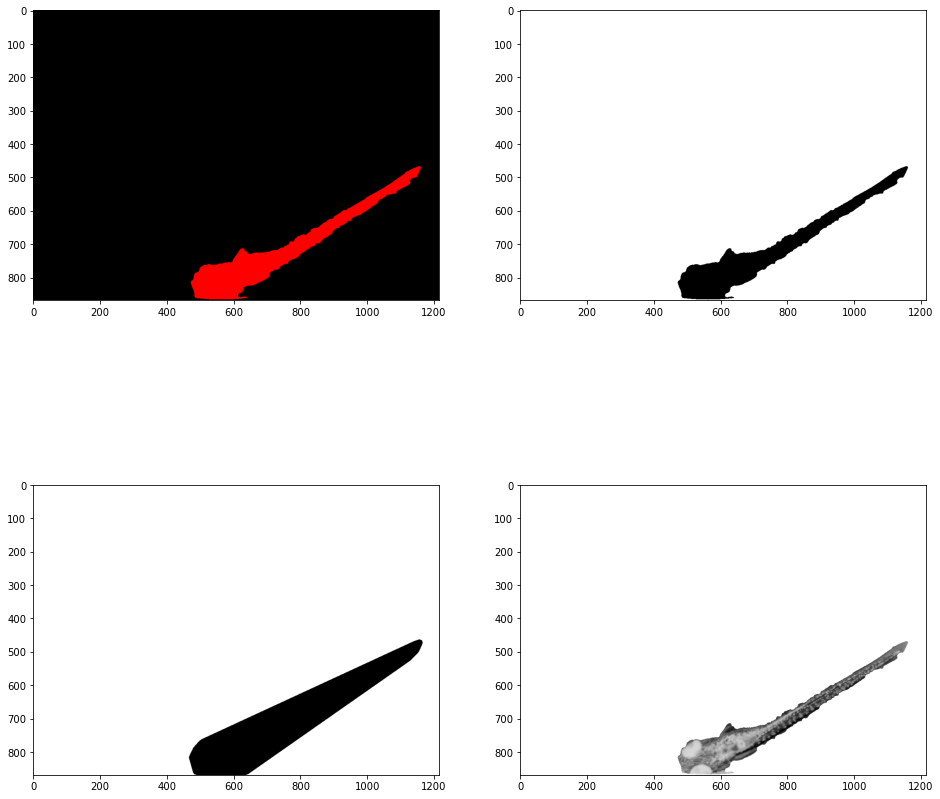

In [24]:
from skimage.color import label2rgb
from skimage.measure import label, regionprops_table

#labeled = label(input_img.fish_props.mask.og * binary_closing(fishy, disk(5)))
labeled = label(fishy.astype(bool))
props = regionprops_table(labeled, properties=('label', 'bbox', 'area'))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

largest_label = keep_largest_object(labeled)
hull = convex_hull_image(keep_largest_object(labeled))
hull = binary_dilation(hull, disk(5))

ax[0].imshow(label2rgb(labeled))
ax[1].imshow(largest_label, 'binary')
ax[2].imshow(hull, 'binary')
ax[3].imshow(largest_label * input_img.well_props.mask.cropped_masked, 'binary')

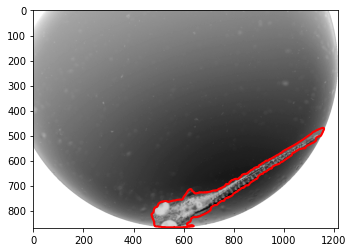

In [25]:
contour = find_contours(largest_label)

plt.imshow(input_img.well_props.mask.cropped_masked, 'binary')
for cont in contour:
    plt.plot(cont[:, 1], cont[:, 0], linewidth=2, color='red')